In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_only_conv_pool_3_ch_128_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=128, strides=1, 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=128*(2**int((i+1)/2)), strides=1, 
                          activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [9]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_128_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15976, 128)        3328      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5326, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 681728)            0         
_________________________________________________________________
dropout (Dropout)            (None, 681728)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                10907664  
Total params: 10,910,992
Trainable params: 10,910,992
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 15976, 128)        3328      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5326, 128)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 5302, 128)         409728    
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1768, 128)         0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 1744, 256)         819456    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 582, 256)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 558, 256)          1638656   
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0460 - acc: 0.3624
Epoch 00001: val_loss improved from inf to 1.63198, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_1_conv_checkpoint/001-1.6320.hdf5
36805/36805 [==============================] - 29s 794us/sample - loss: 2.0460 - acc: 0.3623 - val_loss: 1.6320 - val_acc: 0.5045
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4102 - acc: 0.5687
Epoch 00002: val_loss improved from 1.63198 to 1.49413, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_1_conv_checkpoint/002-1.4941.hdf5
36805/36805 [==============================] - 26s 719us/sample - loss: 1.4103 - acc: 0.5687 - val_loss: 1.4941 - val_acc: 0.5341
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1731 - acc: 0.6398
Epoch 00003: val_loss improved from 1.49413 t

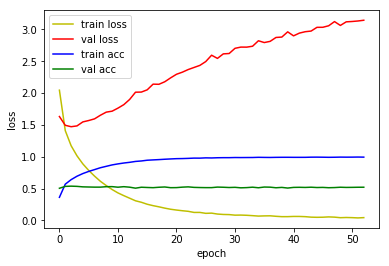

4815/4815 [==============================] - 3s 598us/sample - loss: 1.5494 - acc: 0.5148
Loss: 1.5493722049122907 Accuracy: 0.5148494

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7811 - acc: 0.4333
Epoch 00001: val_loss improved from inf to 1.29042, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_2_conv_checkpoint/001-1.2904.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.7810 - acc: 0.4333 - val_loss: 1.2904 - val_acc: 0.6210
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1917 - acc: 0.6380
Epoch 00002: val_loss improved from 1.29042 to 1.10469, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_2_conv_checkpoint/002-1.1047.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.1917 - acc: 0.6380 - val_loss: 1.1047 - val_acc: 0.6697
Epoch 3/500
36800/36805 [============================>.] 

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0372 - acc: 0.9927
Epoch 00029: val_loss did not improve from 0.98718
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0372 - acc: 0.9927 - val_loss: 1.6856 - val_acc: 0.7216
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9902
Epoch 00030: val_loss did not improve from 0.98718
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0439 - acc: 0.9902 - val_loss: 1.7433 - val_acc: 0.7172
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9924
Epoch 00031: val_loss did not improve from 0.98718
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0378 - acc: 0.9924 - val_loss: 1.6926 - val_acc: 0.7272
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0350 - acc: 0.9933
Epoch 00032: val_loss did not improve from 0.98718
36805/36805 [===========

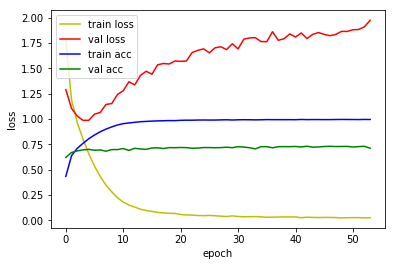

4815/4815 [==============================] - 4s 908us/sample - loss: 1.0962 - acc: 0.6536
Loss: 1.0961564106857047 Accuracy: 0.6535826

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7069 - acc: 0.4549
Epoch 00001: val_loss improved from inf to 1.28156, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_3_conv_checkpoint/001-1.2816.hdf5
36805/36805 [==============================] - 59s 2ms/sample - loss: 1.7068 - acc: 0.4549 - val_loss: 1.2816 - val_acc: 0.5945
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0513 - acc: 0.6839
Epoch 00002: val_loss improved from 1.28156 to 0.93571, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_3_conv_checkpoint/002-0.9357.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 1.0512 - acc: 0.6839 - val_loss: 0.9357 - val_acc: 0.7226
Epoch 3/500
36800/36805 [============================>.] 

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0182 - acc: 0.9968
Epoch 00057: val_loss did not improve from 0.58142
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0182 - acc: 0.9968 - val_loss: 1.0257 - val_acc: 0.8579
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0204 - acc: 0.9957
Epoch 00058: val_loss did not improve from 0.58142
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0204 - acc: 0.9957 - val_loss: 1.0545 - val_acc: 0.8470
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0178 - acc: 0.9971
Epoch 00059: val_loss did not improve from 0.58142
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0178 - acc: 0.9971 - val_loss: 1.0530 - val_acc: 0.8488

1D_CNN_only_conv_pool_3_ch_128_DO_3_conv Model


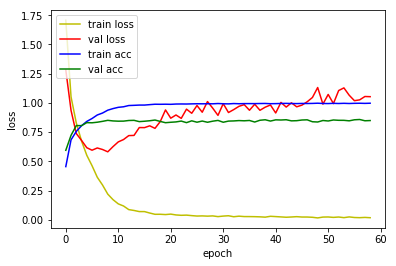

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.6990 - acc: 0.8133
Loss: 0.6989705191718207 Accuracy: 0.8132918

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7545 - acc: 0.4336
Epoch 00001: val_loss improved from inf to 1.13161, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_4_conv_checkpoint/001-1.1316.hdf5
36805/36805 [==============================] - 69s 2ms/sample - loss: 1.7544 - acc: 0.4336 - val_loss: 1.1316 - val_acc: 0.6389
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9391 - acc: 0.7132
Epoch 00002: val_loss improved from 1.13161 to 0.65744, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_4_conv_checkpoint/002-0.6574.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.9390 - acc: 0.7132 - val_loss: 0.6574 - val_acc: 0.8120
Epoch 3/500
36800/36805 [============================>.] - 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.9856
Epoch 00026: val_loss did not improve from 0.28820
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0473 - acc: 0.9856 - val_loss: 0.3616 - val_acc: 0.9299
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0484 - acc: 0.9849
Epoch 00027: val_loss did not improve from 0.28820
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0484 - acc: 0.9849 - val_loss: 0.3811 - val_acc: 0.9231
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0448 - acc: 0.9857
Epoch 00028: val_loss did not improve from 0.28820
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0448 - acc: 0.9857 - val_loss: 0.3750 - val_acc: 0.9306
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9867
Epoch 00029: val_loss did not improve from 0.28820
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0178 - acc: 0.9949
Epoch 00056: val_loss did not improve from 0.28820
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0178 - acc: 0.9949 - val_loss: 0.4585 - val_acc: 0.9329
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0176 - acc: 0.9950
Epoch 00057: val_loss did not improve from 0.28820
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0176 - acc: 0.9950 - val_loss: 0.4716 - val_acc: 0.9311
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0205 - acc: 0.9936
Epoch 00058: val_loss did not improve from 0.28820
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0205 - acc: 0.9936 - val_loss: 0.4676 - val_acc: 0.9299
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9944
Epoch 00059: val_loss did not improve from 0.28820
36805/36805 [===========

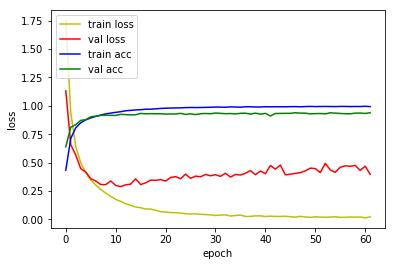

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3615 - acc: 0.9024
Loss: 0.3614852744099507 Accuracy: 0.9023884

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6506 - acc: 0.4605
Epoch 00001: val_loss improved from inf to 0.87589, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_5_conv_checkpoint/001-0.8759.hdf5
36805/36805 [==============================] - 75s 2ms/sample - loss: 1.6505 - acc: 0.4605 - val_loss: 0.8759 - val_acc: 0.7389
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7147 - acc: 0.7772
Epoch 00002: val_loss improved from 0.87589 to 0.42638, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_5_conv_checkpoint/002-0.4264.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.7147 - acc: 0.7772 - val_loss: 0.4264 - val_acc: 0.8747
Epoch 3/500
36800/36805 [============================>.] - 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9889
Epoch 00027: val_loss did not improve from 0.17447
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0337 - acc: 0.9889 - val_loss: 0.2107 - val_acc: 0.9555
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9897
Epoch 00028: val_loss did not improve from 0.17447
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0319 - acc: 0.9897 - val_loss: 0.2429 - val_acc: 0.9562
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0278 - acc: 0.9910
Epoch 00029: val_loss did not improve from 0.17447
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0278 - acc: 0.9910 - val_loss: 0.2472 - val_acc: 0.9532
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 0.9889
Epoch 00030: val_loss did not improve from 0.17447
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0160 - acc: 0.9950
Epoch 00057: val_loss did not improve from 0.17447
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.0160 - acc: 0.9950 - val_loss: 0.2775 - val_acc: 0.9557
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0124 - acc: 0.9962
Epoch 00058: val_loss did not improve from 0.17447
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0124 - acc: 0.9962 - val_loss: 0.2644 - val_acc: 0.9574
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0141 - acc: 0.9953
Epoch 00059: val_loss did not improve from 0.17447
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.0141 - acc: 0.9953 - val_loss: 0.2831 - val_acc: 0.9555
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0136 - acc: 0.9958
Epoch 00060: val_loss did not improve from 0.17447
36805/36805 [===========

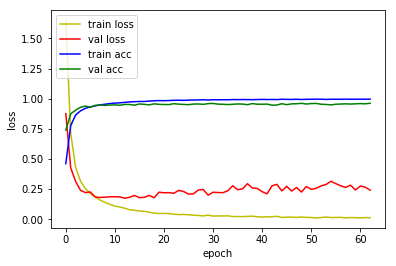

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.2095 - acc: 0.9398
Loss: 0.20949265607482795 Accuracy: 0.93977153

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5553 - acc: 0.4879
Epoch 00001: val_loss improved from inf to 0.79176, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_6_conv_checkpoint/001-0.7918.hdf5
36805/36805 [==============================] - 81s 2ms/sample - loss: 1.5552 - acc: 0.4879 - val_loss: 0.7918 - val_acc: 0.7491
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6461 - acc: 0.7977
Epoch 00002: val_loss improved from 0.79176 to 0.36886, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_6_conv_checkpoint/002-0.3689.hdf5
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.6461 - acc: 0.7977 - val_loss: 0.3689 - val_acc: 0.8861
Epoch 3/500
36800/36805 [============================>.] 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9906
Epoch 00028: val_loss did not improve from 0.14155
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.0308 - acc: 0.9906 - val_loss: 0.1988 - val_acc: 0.9604
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0355 - acc: 0.9899
Epoch 00029: val_loss did not improve from 0.14155
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.0355 - acc: 0.9899 - val_loss: 0.2149 - val_acc: 0.9599
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0259 - acc: 0.9925
Epoch 00030: val_loss did not improve from 0.14155
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.0259 - acc: 0.9925 - val_loss: 0.1865 - val_acc: 0.9602
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0334 - acc: 0.9894
Epoch 00031: val_loss did not improve from 0.14155
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0162 - acc: 0.9957
Epoch 00058: val_loss did not improve from 0.14155
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0162 - acc: 0.9957 - val_loss: 0.2804 - val_acc: 0.9592
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0157 - acc: 0.9956
Epoch 00059: val_loss did not improve from 0.14155
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.0157 - acc: 0.9956 - val_loss: 0.2426 - val_acc: 0.9609
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0158 - acc: 0.9957
Epoch 00060: val_loss did not improve from 0.14155
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.0157 - acc: 0.9957 - val_loss: 0.2624 - val_acc: 0.9620

1D_CNN_only_conv_pool_3_ch_128_DO_6_conv Model


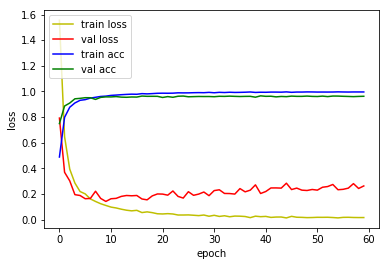

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.2078 - acc: 0.9391
Loss: 0.20782620130050714 Accuracy: 0.9391485



In [10]:
for i in range(1, 7):
    base = '1D_CNN_only_conv_pool_3_ch_128_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_128_DO(conv_num=i)
    
    model = multi_gpu_model(model, gpus=2)
    
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [12]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_only_conv_pool_3_ch_128_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 7):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_only_conv_pool_3_ch_128_DO_1_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_21_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_21_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_21_input[0][0]            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 16)           10910992    lambda[0][0]                     
                                                             

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.2095 - acc: 0.9398
Loss: 0.20949265607482795 Accuracy: 0.93977153

1D_CNN_only_conv_pool_3_ch_128_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_36_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_36_input[0][0]            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_36_input[0][0]            
__________________________________________________________________________________________________
sequential_11 (Sequential

In [8]:
def build_1d_cnn_only_conv_pool_3_ch_128_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=128, strides=1, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=128*(2**int((i+1)/2)), strides=1))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [9]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_128_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15976, 128)        3328      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 15976, 128)        512       
_________________________________________________________________
activation (Activation)      (None, 15976, 128)        0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5326, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 681728)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                10907664  
Total params: 10,911,504
Trainable params: 10,911,248
Non-trainable pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 15976, 128)        3328      
_________________________________________________________________
batch_normalization_v1_15 (B (None, 15976, 128)        512       
_________________________________________________________________
activation_15 (Activation)   (None, 15976, 128)        0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5326, 128)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 5302, 128)         409728    
_________________________________________________________________
batch_normalization_v1_16 (B (None, 5302, 128)         512       
_________________________________________________________________
activation_16 (Activation)   (None, 5302, 128)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.9492 - acc: 0.3552
Epoch 00001: val_loss improved from inf to 1.90860, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_BN_1_conv_checkpoint/001-1.9086.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 2.9490 - acc: 0.3553 - val_loss: 1.9086 - val_acc: 0.4559
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2763 - acc: 0.6180
Epoch 00002: val_loss did not improve from 1.90860
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.2763 - acc: 0.6180 - val_loss: 1.9625 - val_acc: 0.4682
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8999 - acc: 0.7223
Epoch 00003: val_loss did not improve from 1.90860
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.8999 - acc: 0.7223 - val_loss: 2

36800/36805 [============================>.] - ETA: 0s - loss: 0.0912 - acc: 0.9813
Epoch 00029: val_loss did not improve from 1.90860
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0912 - acc: 0.9813 - val_loss: 4.0818 - val_acc: 0.4952
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0691 - acc: 0.9874
Epoch 00030: val_loss did not improve from 1.90860
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0691 - acc: 0.9874 - val_loss: 4.1800 - val_acc: 0.4938
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1034 - acc: 0.9796
Epoch 00031: val_loss did not improve from 1.90860
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1034 - acc: 0.9796 - val_loss: 4.2308 - val_acc: 0.4959
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1194 - acc: 0.9745
Epoch 00032: val_loss did not improve from 1.90860
36805/36805 [========================

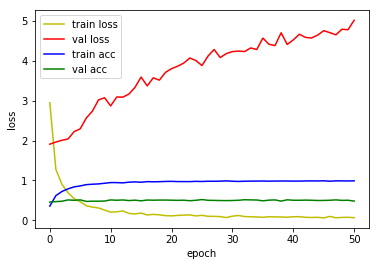

4815/4815 [==============================] - 4s 751us/sample - loss: 2.0035 - acc: 0.4417
Loss: 2.0035326047354647 Accuracy: 0.44174454

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6579 - acc: 0.3987
Epoch 00001: val_loss improved from inf to 2.59614, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_BN_2_conv_checkpoint/001-2.5961.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 2.6579 - acc: 0.3987 - val_loss: 2.5961 - val_acc: 0.4142
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8313 - acc: 0.5959
Epoch 00002: val_loss improved from 2.59614 to 2.03625, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_BN_2_conv_checkpoint/002-2.0363.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.8312 - acc: 0.5959 - val_loss: 2.0363 - val_acc: 0.5679
Epoch 3/500
36800/36805 [============================>.]

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6383 - acc: 0.9490
Epoch 00029: val_loss did not improve from 1.88976
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.6383 - acc: 0.9489 - val_loss: 3.1771 - val_acc: 0.6145
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6735 - acc: 0.9383
Epoch 00030: val_loss did not improve from 1.88976
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.6734 - acc: 0.9383 - val_loss: 3.2639 - val_acc: 0.6101
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6528 - acc: 0.9436
Epoch 00031: val_loss did not improve from 1.88976
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.6529 - acc: 0.9436 - val_loss: 3.4505 - val_acc: 0.5996
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6608 - acc: 0.9425
Epoch 00032: val_loss did not improve from 1.88976
36805/36805 [===========

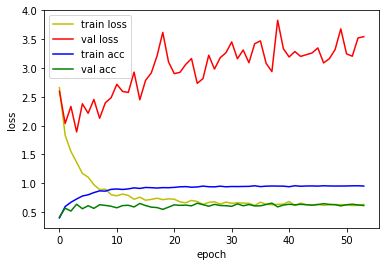

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.9743 - acc: 0.6108
Loss: 1.9743233739029953 Accuracy: 0.6107996

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2784 - acc: 0.4717
Epoch 00001: val_loss improved from inf to 1.50536, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_BN_3_conv_checkpoint/001-1.5054.hdf5
36805/36805 [==============================] - 121s 3ms/sample - loss: 2.2782 - acc: 0.4717 - val_loss: 1.5054 - val_acc: 0.5483
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1326 - acc: 0.6740
Epoch 00002: val_loss improved from 1.50536 to 1.10040, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_BN_3_conv_checkpoint/002-1.1004.hdf5
36805/36805 [==============================] - 118s 3ms/sample - loss: 1.1328 - acc: 0.6740 - val_loss: 1.1004 - val_acc: 0.7133
Epoch 3/500
36800/36805 [============================>.] 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0804 - acc: 0.9790
Epoch 00028: val_loss did not improve from 0.77979
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.0804 - acc: 0.9790 - val_loss: 1.0966 - val_acc: 0.8227
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0758 - acc: 0.9783
Epoch 00029: val_loss did not improve from 0.77979
36805/36805 [==============================] - 118s 3ms/sample - loss: 0.0758 - acc: 0.9783 - val_loss: 1.7110 - val_acc: 0.7633
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0859 - acc: 0.9754
Epoch 00030: val_loss did not improve from 0.77979
36805/36805 [==============================] - 118s 3ms/sample - loss: 0.0859 - acc: 0.9754 - val_loss: 1.1523 - val_acc: 0.8118
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0484 - acc: 0.9868
Epoch 00031: val_loss did not improve from 0.77979
36805/36805 [=====================

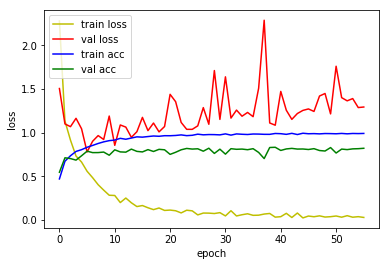

4815/4815 [==============================] - 7s 2ms/sample - loss: 0.9208 - acc: 0.7502
Loss: 0.9208016629654794 Accuracy: 0.75015575

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3996 - acc: 0.5707
Epoch 00001: val_loss improved from inf to 0.94443, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_BN_4_conv_checkpoint/001-0.9444.hdf5
36805/36805 [==============================] - 138s 4ms/sample - loss: 1.3995 - acc: 0.5707 - val_loss: 0.9444 - val_acc: 0.7379
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7592 - acc: 0.7745
Epoch 00002: val_loss improved from 0.94443 to 0.70883, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_BN_4_conv_checkpoint/002-0.7088.hdf5
36805/36805 [==============================] - 133s 4ms/sample - loss: 0.7593 - acc: 0.7744 - val_loss: 0.7088 - val_acc: 0.7897
Epoch 3/500
36800/36805 [============================>.]

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0546 - acc: 0.9826
Epoch 00028: val_loss did not improve from 0.39132
36805/36805 [==============================] - 133s 4ms/sample - loss: 0.0548 - acc: 0.9826 - val_loss: 0.4839 - val_acc: 0.9015
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0533 - acc: 0.9824
Epoch 00029: val_loss did not improve from 0.39132
36805/36805 [==============================] - 134s 4ms/sample - loss: 0.0534 - acc: 0.9824 - val_loss: 0.4500 - val_acc: 0.9094
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0411 - acc: 0.9872
Epoch 00030: val_loss did not improve from 0.39132
36805/36805 [==============================] - 134s 4ms/sample - loss: 0.0414 - acc: 0.9871 - val_loss: 0.4917 - val_acc: 0.9066
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0889 - acc: 0.9751
Epoch 00031: val_loss did not improve from 0.39132
36805/36805 [========


1D_CNN_only_conv_pool_3_ch_128_BN_4_conv Model


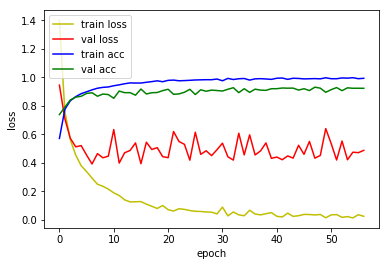

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.4610 - acc: 0.8611
Loss: 0.4610105646485975 Accuracy: 0.8610592

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1332 - acc: 0.6486
Epoch 00001: val_loss improved from inf to 0.63469, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_BN_5_conv_checkpoint/001-0.6347.hdf5
36805/36805 [==============================] - 147s 4ms/sample - loss: 1.1334 - acc: 0.6486 - val_loss: 0.6347 - val_acc: 0.8157
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4889 - acc: 0.8509
Epoch 00002: val_loss improved from 0.63469 to 0.39687, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_BN_5_conv_checkpoint/002-0.3969.hdf5
36805/36805 [==============================] - 142s 4ms/sample - loss: 0.4891 - acc: 0.8508 - val_loss: 0.3969 - val_acc: 0.8812
Epoch 3/500
36800/36805 [============================>.] 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0494 - acc: 0.9843
Epoch 00027: val_loss improved from 0.19755 to 0.17858, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_BN_5_conv_checkpoint/027-0.1786.hdf5
36805/36805 [==============================] - 141s 4ms/sample - loss: 0.0494 - acc: 0.9843 - val_loss: 0.1786 - val_acc: 0.9578
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9917
Epoch 00028: val_loss did not improve from 0.17858
36805/36805 [==============================] - 141s 4ms/sample - loss: 0.0266 - acc: 0.9916 - val_loss: 0.2211 - val_acc: 0.9525
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0400 - acc: 0.9862
Epoch 00029: val_loss did not improve from 0.17858
36805/36805 [==============================] - 140s 4ms/sample - loss: 0.0400 - acc: 0.9862 - val_loss: 0.1956 - val_acc: 0.9557
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9917
Epoch 00056: val_loss did not improve from 0.17401
36805/36805 [==============================] - 140s 4ms/sample - loss: 0.0280 - acc: 0.9917 - val_loss: 0.2167 - val_acc: 0.9585
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0072 - acc: 0.9980
Epoch 00057: val_loss did not improve from 0.17401
36805/36805 [==============================] - 140s 4ms/sample - loss: 0.0073 - acc: 0.9979 - val_loss: 0.2055 - val_acc: 0.9604
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0252 - acc: 0.9921
Epoch 00058: val_loss did not improve from 0.17401
36805/36805 [==============================] - 140s 4ms/sample - loss: 0.0252 - acc: 0.9921 - val_loss: 0.2270 - val_acc: 0.9599
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0083 - acc: 0.9971
Epoch 00059: val_loss did not improve from 0.17401
36805/36805 [========


1D_CNN_only_conv_pool_3_ch_128_BN_5_conv Model


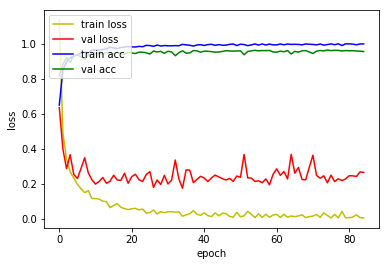

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2664 - acc: 0.9412
Loss: 0.26641650329250166 Accuracy: 0.94122535

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9367 - acc: 0.7090
Epoch 00001: val_loss improved from inf to 0.51667, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_BN_6_conv_checkpoint/001-0.5167.hdf5
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.9366 - acc: 0.7091 - val_loss: 0.5167 - val_acc: 0.8337
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3706 - acc: 0.8867
Epoch 00002: val_loss improved from 0.51667 to 0.29477, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_BN_6_conv_checkpoint/002-0.2948.hdf5
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.3708 - acc: 0.8866 - val_loss: 0.2948 - val_acc: 0.9119
Epoch 3/500
36800/36805 [============================>.

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0197 - acc: 0.9950
Epoch 00026: val_loss did not improve from 0.11133
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0198 - acc: 0.9950 - val_loss: 0.1165 - val_acc: 0.9676
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0293 - acc: 0.9921
Epoch 00027: val_loss did not improve from 0.11133
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0293 - acc: 0.9920 - val_loss: 0.1346 - val_acc: 0.9627
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.9920
Epoch 00028: val_loss did not improve from 0.11133
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0283 - acc: 0.9920 - val_loss: 0.1287 - val_acc: 0.9688
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0151 - acc: 0.9964
Epoch 00029: val_loss did not improve from 0.11133
36805/36805 [========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0105 - acc: 0.9970
Epoch 00056: val_loss did not improve from 0.11133
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0105 - acc: 0.9970 - val_loss: 0.2036 - val_acc: 0.9567
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0170 - acc: 0.9955
Epoch 00057: val_loss did not improve from 0.11133
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0171 - acc: 0.9954 - val_loss: 0.1599 - val_acc: 0.9623
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0148 - acc: 0.9960
Epoch 00058: val_loss did not improve from 0.11133
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0149 - acc: 0.9960 - val_loss: 0.1289 - val_acc: 0.9693
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9976
Epoch 00059: val_loss did not improve from 0.11133
36805/36805 [========

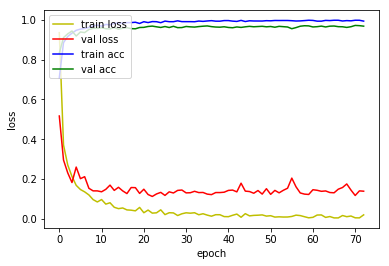

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.1709 - acc: 0.9526
Loss: 0.1708795553458195 Accuracy: 0.952648



In [10]:
for i in range(1, 7):
    base = '1D_CNN_only_conv_pool_3_ch_128_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_128_BN(conv_num=i)
    
    model = multi_gpu_model(model, gpus=2)
    
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_only_conv_pool_3_ch_128_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 7):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_only_conv_pool_3_ch_128_BN_1_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_63_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 16000, 1)     0           conv1d_63_input[0][0]            
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 16000, 1)     0           conv1d_63_input[0][0]            
__________________________________________________________________________________________________
sequential_18 (Sequential)      (None, 16)           10911504    lambda_12[0][0]                  
                                                             

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2664 - acc: 0.9412
Loss: 0.26641650329250166 Accuracy: 0.94122535

1D_CNN_only_conv_pool_3_ch_128_BN_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_36_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_36_input[0][0]            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_36_input[0][0]            
__________________________________________________________________________________________________
sequential_11 (Sequential

In [12]:
def build_1d_cnn_only_conv_pool_3_ch_128_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=128, strides=1, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=128*(2**int((i+1)/2)), strides=1))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [13]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_128_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 15976, 128)        3328      
_________________________________________________________________
batch_normalization_v1_42 (B (None, 15976, 128)        512       
_________________________________________________________________
activation_42 (Activation)   (None, 15976, 128)        0         
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 5326, 128)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 681728)            0         
_________________________________________________________________
dropout (Dropout)            (None, 681728)            0         
___________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_52 (Conv1D)           (None, 15976, 128)        3328      
_________________________________________________________________
batch_normalization_v1_52 (B (None, 15976, 128)        512       
_________________________________________________________________
activation_52 (Activation)   (None, 15976, 128)        0         
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 5326, 128)         0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 5302, 128)         409728    
_________________________________________________________________
batch_normalization_v1_53 (B (None, 5302, 128)         512       
_________________________________________________________________
activation_53 (Activation)   (None, 5302, 128)         0         
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3601 - acc: 0.3631
Epoch 00001: val_loss improved from inf to 1.84305, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_BN_1_conv_checkpoint/001-1.8431.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 2.3600 - acc: 0.3631 - val_loss: 1.8431 - val_acc: 0.4663
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2732 - acc: 0.6061
Epoch 00002: val_loss improved from 1.84305 to 1.78507, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_BN_1_conv_checkpoint/002-1.7851.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.2732 - acc: 0.6061 - val_loss: 1.7851 - val_acc: 0.4969
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9532 - acc: 0.7020
Epoch 00003: val_loss did not improve from 1.78507
36805/36805 [===========================

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1040 - acc: 0.9726
Epoch 00030: val_loss did not improve from 1.78507
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1040 - acc: 0.9726 - val_loss: 3.6791 - val_acc: 0.5218
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1179 - acc: 0.9693
Epoch 00031: val_loss did not improve from 1.78507
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1181 - acc: 0.9693 - val_loss: 3.9520 - val_acc: 0.5085
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1199 - acc: 0.9702
Epoch 00032: val_loss did not improve from 1.78507
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1199 - acc: 0.9702 - val_loss: 3.8613 - val_acc: 0.5176
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1058 - acc: 0.9733
Epoch 00033: val_loss did not improve from 1.78507
36805/36805 [===========

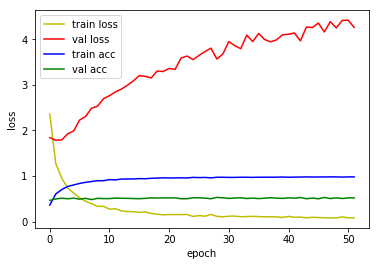

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.8943 - acc: 0.4673
Loss: 1.8943370818596639 Accuracy: 0.46728972

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6851 - acc: 0.3847
Epoch 00001: val_loss improved from inf to 2.29267, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_BN_2_conv_checkpoint/001-2.2927.hdf5
36805/36805 [==============================] - 100s 3ms/sample - loss: 2.6851 - acc: 0.3846 - val_loss: 2.2927 - val_acc: 0.4976
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9927 - acc: 0.5618
Epoch 00002: val_loss improved from 2.29267 to 2.11738, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_BN_2_conv_checkpoint/002-2.1174.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.9926 - acc: 0.5618 - val_loss: 2.1174 - val_acc: 0.5523
Epoch 3/500
36800/36805 [==========================

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7558 - acc: 0.9126
Epoch 00029: val_loss did not improve from 1.93082
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.7557 - acc: 0.9126 - val_loss: 2.8271 - val_acc: 0.6406
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6895 - acc: 0.9306
Epoch 00030: val_loss did not improve from 1.93082
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.6894 - acc: 0.9306 - val_loss: 2.3760 - val_acc: 0.6643
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6930 - acc: 0.9298
Epoch 00031: val_loss did not improve from 1.93082
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.6931 - acc: 0.9297 - val_loss: 2.7387 - val_acc: 0.6313
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6856 - acc: 0.9321
Epoch 00032: val_loss did not improve from 1.93082
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0541 - acc: 0.9857
Epoch 00058: val_loss did not improve from 1.85245
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0541 - acc: 0.9857 - val_loss: 2.0349 - val_acc: 0.6916
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0539 - acc: 0.9863
Epoch 00059: val_loss did not improve from 1.85245
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0541 - acc: 0.9863 - val_loss: 2.2638 - val_acc: 0.6778
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0652 - acc: 0.9829
Epoch 00060: val_loss did not improve from 1.85245
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0652 - acc: 0.9829 - val_loss: 2.5718 - val_acc: 0.6485
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0560 - acc: 0.9855
Epoch 00061: val_loss did not improve from 1.85245
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0562 - acc: 0.9858
Epoch 00087: val_loss did not improve from 1.83222
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0562 - acc: 0.9858 - val_loss: 1.9822 - val_acc: 0.7098
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9931
Epoch 00088: val_loss did not improve from 1.83222
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0322 - acc: 0.9931 - val_loss: 1.9417 - val_acc: 0.7335
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0348 - acc: 0.9927
Epoch 00089: val_loss did not improve from 1.83222
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0348 - acc: 0.9927 - val_loss: 2.1631 - val_acc: 0.7079
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0341 - acc: 0.9924
Epoch 00090: val_loss did not improve from 1.83222
36805/36805 [========================

Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0243 - acc: 0.9955
Epoch 00117: val_loss did not improve from 1.83222
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0243 - acc: 0.9955 - val_loss: 1.9044 - val_acc: 0.7284
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9942
Epoch 00118: val_loss did not improve from 1.83222
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0290 - acc: 0.9942 - val_loss: 1.9103 - val_acc: 0.7303
Epoch 119/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0257 - acc: 0.9954
Epoch 00119: val_loss did not improve from 1.83222
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0257 - acc: 0.9954 - val_loss: 1.9842 - val_acc: 0.7172
Epoch 120/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0274 - acc: 0.9947
Epoch 00120: val_loss did not improve from 1.83222
36805/36805 [=======

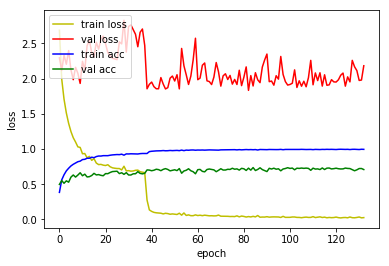

4815/4815 [==============================] - 7s 1ms/sample - loss: 2.1254 - acc: 0.6928
Loss: 2.1253664829773076 Accuracy: 0.6928349

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0272 - acc: 0.4442
Epoch 00001: val_loss improved from inf to 1.50048, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_BN_3_conv_checkpoint/001-1.5005.hdf5
36805/36805 [==============================] - 128s 3ms/sample - loss: 2.0271 - acc: 0.4442 - val_loss: 1.5005 - val_acc: 0.5823
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2438 - acc: 0.6425
Epoch 00002: val_loss improved from 1.50048 to 0.97863, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_BN_3_conv_checkpoint/002-0.9786.hdf5
36805/36805 [==============================] - 115s 3ms/sample - loss: 1.2440 - acc: 0.6425 - val_loss: 0.9786 - val_acc: 0.7174
Epoch 3/500
36800/36805 [==========================

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1202 - acc: 0.9636
Epoch 00028: val_loss did not improve from 0.71498
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.1206 - acc: 0.9635 - val_loss: 1.0324 - val_acc: 0.8125
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1215 - acc: 0.9626
Epoch 00029: val_loss did not improve from 0.71498
36805/36805 [==============================] - 116s 3ms/sample - loss: 0.1215 - acc: 0.9626 - val_loss: 0.8718 - val_acc: 0.8442
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1030 - acc: 0.9687
Epoch 00030: val_loss did not improve from 0.71498
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.1031 - acc: 0.9686 - val_loss: 0.9960 - val_acc: 0.8311
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1108 - acc: 0.9667
Epoch 00031: val_loss did not improve from 0.71498
36805/36805 [========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0558 - acc: 0.9842
Epoch 00058: val_loss did not improve from 0.71498
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0558 - acc: 0.9841 - val_loss: 0.9712 - val_acc: 0.8521

1D_CNN_only_conv_pool_3_ch_128_DO_BN_3_conv Model


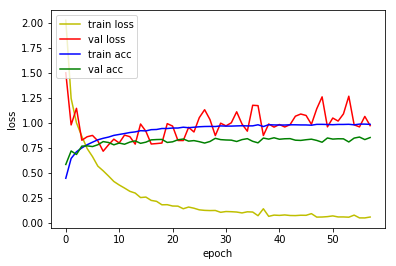

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.8471 - acc: 0.7691
Loss: 0.8471282986094276 Accuracy: 0.769055

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7560 - acc: 0.4754
Epoch 00001: val_loss improved from inf to 1.19761, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_BN_4_conv_checkpoint/001-1.1976.hdf5
36805/36805 [==============================] - 144s 4ms/sample - loss: 1.7561 - acc: 0.4754 - val_loss: 1.1976 - val_acc: 0.6466
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9675 - acc: 0.7070
Epoch 00002: val_loss improved from 1.19761 to 0.77703, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_BN_4_conv_checkpoint/002-0.7770.hdf5
36805/36805 [==============================] - 131s 4ms/sample - loss: 0.9676 - acc: 0.7069 - val_loss: 0.7770 - val_acc: 0.7729
Epoch 3/500
36800/36805 [===========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0973 - acc: 0.9679
Epoch 00026: val_loss improved from 0.34122 to 0.33115, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_BN_4_conv_checkpoint/026-0.3311.hdf5
36805/36805 [==============================] - 130s 4ms/sample - loss: 0.0973 - acc: 0.9679 - val_loss: 0.3311 - val_acc: 0.9280
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0895 - acc: 0.9712
Epoch 00027: val_loss did not improve from 0.33115
36805/36805 [==============================] - 130s 4ms/sample - loss: 0.0895 - acc: 0.9712 - val_loss: 0.3753 - val_acc: 0.9171
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0931 - acc: 0.9686
Epoch 00028: val_loss did not improve from 0.33115
36805/36805 [==============================] - 130s 4ms/sample - loss: 0.0931 - acc: 0.9686 - val_loss: 0.3928 - val_acc: 0.9203
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0346 - acc: 0.9888
Epoch 00055: val_loss did not improve from 0.31270
36805/36805 [==============================] - 130s 4ms/sample - loss: 0.0349 - acc: 0.9888 - val_loss: 0.4066 - val_acc: 0.9243
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0471 - acc: 0.9856
Epoch 00056: val_loss did not improve from 0.31270
36805/36805 [==============================] - 131s 4ms/sample - loss: 0.0471 - acc: 0.9856 - val_loss: 0.3822 - val_acc: 0.9313
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9880
Epoch 00057: val_loss did not improve from 0.31270
36805/36805 [==============================] - 130s 4ms/sample - loss: 0.0357 - acc: 0.9879 - val_loss: 0.4211 - val_acc: 0.9229
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9874
Epoch 00058: val_loss did not improve from 0.31270
36805/36805 [========


1D_CNN_only_conv_pool_3_ch_128_DO_BN_4_conv Model


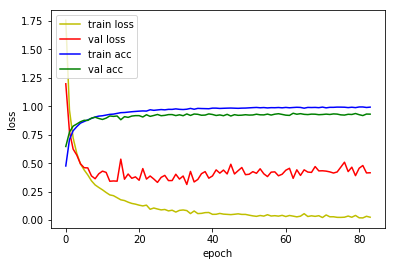

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.3724 - acc: 0.9171
Loss: 0.3724484314768733 Accuracy: 0.9171339

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5289 - acc: 0.5357
Epoch 00001: val_loss improved from inf to 0.78459, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_BN_5_conv_checkpoint/001-0.7846.hdf5
36805/36805 [==============================] - 155s 4ms/sample - loss: 1.5288 - acc: 0.5357 - val_loss: 0.7846 - val_acc: 0.7694
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6870 - acc: 0.7926
Epoch 00002: val_loss improved from 0.78459 to 0.52098, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_BN_5_conv_checkpoint/002-0.5210.hdf5
36805/36805 [==============================] - 144s 4ms/sample - loss: 0.6871 - acc: 0.7926 - val_loss: 0.5210 - val_acc: 0.8526
Epoch 3/500
36800/36805 [==========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0619 - acc: 0.9794
Epoch 00026: val_loss did not improve from 0.16221
36805/36805 [==============================] - 143s 4ms/sample - loss: 0.0620 - acc: 0.9794 - val_loss: 0.1946 - val_acc: 0.9541
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0683 - acc: 0.9772
Epoch 00027: val_loss did not improve from 0.16221
36805/36805 [==============================] - 141s 4ms/sample - loss: 0.0683 - acc: 0.9771 - val_loss: 0.2136 - val_acc: 0.9529
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0619 - acc: 0.9790
Epoch 00028: val_loss did not improve from 0.16221
36805/36805 [==============================] - 143s 4ms/sample - loss: 0.0619 - acc: 0.9790 - val_loss: 0.2486 - val_acc: 0.9448
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0543 - acc: 0.9824
Epoch 00029: val_loss did not improve from 0.16221
36805/36805 [=====================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0185 - acc: 0.9942
Epoch 00056: val_loss did not improve from 0.16221
36805/36805 [==============================] - 143s 4ms/sample - loss: 0.0185 - acc: 0.9942 - val_loss: 0.2218 - val_acc: 0.9585
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.9903
Epoch 00057: val_loss did not improve from 0.16221
36805/36805 [==============================] - 141s 4ms/sample - loss: 0.0305 - acc: 0.9903 - val_loss: 0.2100 - val_acc: 0.9606
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9917
Epoch 00058: val_loss did not improve from 0.16221
36805/36805 [==============================] - 143s 4ms/sample - loss: 0.0258 - acc: 0.9917 - val_loss: 0.2287 - val_acc: 0.9578
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9932
Epoch 00059: val_loss did not improve from 0.16221
36805/36805 [========

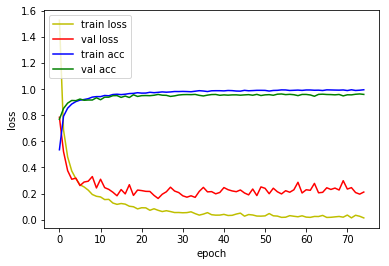

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.2247 - acc: 0.9462
Loss: 0.22465035512304535 Accuracy: 0.9462098

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3568 - acc: 0.5850
Epoch 00001: val_loss improved from inf to 0.58638, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_BN_6_conv_checkpoint/001-0.5864.hdf5
36805/36805 [==============================] - 168s 5ms/sample - loss: 1.3567 - acc: 0.5850 - val_loss: 0.5864 - val_acc: 0.8279
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5554 - acc: 0.8299
Epoch 00002: val_loss improved from 0.58638 to 0.41120, saving model to model/checkpoint/1D_CNN_only_conv_pool_3_ch_128_DO_BN_6_conv_checkpoint/002-0.4112.hdf5
36805/36805 [==============================] - 153s 4ms/sample - loss: 0.5554 - acc: 0.8299 - val_loss: 0.4112 - val_acc: 0.8744
Epoch 3/500
36800/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0607 - acc: 0.9810
Epoch 00025: val_loss did not improve from 0.11999
36805/36805 [==============================] - 152s 4ms/sample - loss: 0.0610 - acc: 0.9810 - val_loss: 0.1409 - val_acc: 0.9627
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0610 - acc: 0.9805
Epoch 00026: val_loss did not improve from 0.11999
36805/36805 [==============================] - 152s 4ms/sample - loss: 0.0612 - acc: 0.9805 - val_loss: 0.1250 - val_acc: 0.9660
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0534 - acc: 0.9829
Epoch 00027: val_loss did not improve from 0.11999
36805/36805 [==============================] - 152s 4ms/sample - loss: 0.0535 - acc: 0.9829 - val_loss: 0.1204 - val_acc: 0.9706
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0529 - acc: 0.9835
Epoch 00028: val_loss improved from 0.11999 to 0.10669, saving model to model/checkpo

36800/36805 [============================>.] - ETA: 0s - loss: 0.0241 - acc: 0.9931
Epoch 00054: val_loss did not improve from 0.10669
36805/36805 [==============================] - 153s 4ms/sample - loss: 0.0241 - acc: 0.9931 - val_loss: 0.1497 - val_acc: 0.9658
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0151 - acc: 0.9959
Epoch 00055: val_loss did not improve from 0.10669
36805/36805 [==============================] - 153s 4ms/sample - loss: 0.0151 - acc: 0.9959 - val_loss: 0.1513 - val_acc: 0.9665
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0149 - acc: 0.9957
Epoch 00056: val_loss did not improve from 0.10669
36805/36805 [==============================] - 153s 4ms/sample - loss: 0.0150 - acc: 0.9956 - val_loss: 0.1350 - val_acc: 0.9702
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9935
Epoch 00057: val_loss did not improve from 0.10669
36805/36805 [=====================

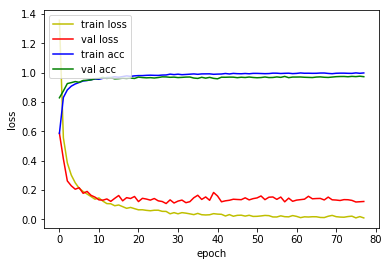

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.1347 - acc: 0.9601
Loss: 0.1346632310722182 Accuracy: 0.9601246



In [14]:
for i in range(1, 7):
    base = '1D_CNN_only_conv_pool_3_ch_128_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_128_DO_BN(conv_num=i)
    
    model = multi_gpu_model(model, gpus=2)
    
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [15]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_only_conv_pool_3_ch_128_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 7):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_only_conv_pool_3_ch_128_DO_BN_1_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_63_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 16000, 1)     0           conv1d_63_input[0][0]            
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 16000, 1)     0           conv1d_63_input[0][0]            
__________________________________________________________________________________________________
sequential_18 (Sequential)      (None, 16)           10911504    lambda_12[0][0]                  
                                                          

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.2247 - acc: 0.9462
Loss: 0.22465035512304535 Accuracy: 0.9462098

1D_CNN_only_conv_pool_3_ch_128_DO_BN_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_78_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_22 (Lambda)              (None, 16000, 1)     0           conv1d_78_input[0][0]            
__________________________________________________________________________________________________
lambda_23 (Lambda)              (None, 16000, 1)     0           conv1d_78_input[0][0]            
__________________________________________________________________________________________________
sequential_23 (Sequent